In [2]:
#@title Import { display-mode: "form" }


from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras as tf_keras

import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm



2024-04-30 12:46:51.783747: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 12:46:51.818368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [4]:
sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [5]:
tf.test.gpu_device_name()

''

In [6]:
rna_df = feather.read_feather("shared_data/rna_df.feather")
expression_df = feather.read_feather("shared_data/expression_df.feather").drop(
    ["key"], axis=1
)
methylation_data_df = feather.read_feather(
    "shared_data/methylation_data_df.feather"
).drop(["PMR_INDEX"], axis=1)

# Convert NumPy array to TensorFlow tensor with specified dtype
meth_data =  methylation_data_df.transpose().astype(np.float64).values
expression_data = expression_df.values.transpose().astype(np.float64)

In [18]:
meth_data

array([[31.65714286, 32.38271605, 42.95238095, ..., 41.64705882,
        54.82692308, 57.25      ],
       [44.08571429, 48.64197531, 70.26190476, ..., 49.09803922,
        64.79807692, 53.33333333],
       [47.74285714, 59.2375    , 74.61904762, ..., 50.17307692,
        68.86792453, 57.66666667],
       ...,
       [36.57142857, 25.4375    , 72.5952381 , ..., 28.38461538,
        33.84761905, 57.58974359],
       [42.74285714, 38.2278481 , 76.5952381 , ..., 34.26923077,
        65.67307692, 49.725     ],
       [42.54285714, 44.16049383, 56.5952381 , ..., 43.44230769,
        58.47169811, 48.725     ]])

In [19]:
meth_data_transformed = meth_data / 100

In [20]:
meth_data_transformed

array([[0.31657143, 0.32382716, 0.42952381, ..., 0.41647059, 0.54826923,
        0.5725    ],
       [0.44085714, 0.48641975, 0.70261905, ..., 0.49098039, 0.64798077,
        0.53333333],
       [0.47742857, 0.592375  , 0.74619048, ..., 0.50173077, 0.68867925,
        0.57666667],
       ...,
       [0.36571429, 0.254375  , 0.72595238, ..., 0.28384615, 0.33847619,
        0.57589744],
       [0.42742857, 0.38227848, 0.76595238, ..., 0.34269231, 0.65673077,
        0.49725   ],
       [0.42542857, 0.44160494, 0.56595238, ..., 0.43442308, 0.58471698,
        0.48725   ]])

In [21]:
expression_data_train, expression_data_test, meth_data_train, meth_data_test = (
    train_test_split(
        expression_data, meth_data_transformed, test_size=0.33, random_state=42
    )
)

In [22]:
x_train = tf.convert_to_tensor(expression_data_train, dtype=tf.float32)
y_train = tf.convert_to_tensor( meth_data_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(expression_data_test, dtype=tf.float32)
y_test = tf.convert_to_tensor( meth_data_test, dtype=tf.float32)

In [23]:
# Reduce data by 80%, keeping only 20%
def reduce_data(x_data, y_data):
    num_data = int(0.20 * len(x_data))
    x_data_reduced = x_data[:num_data]
    y_data_reduced = y_data[:num_data]
    return x_data_reduced, y_data_reduced

x_train_reduced, y_train_reduced = reduce_data(x_train, y_train)
x_test_reduced, y_test_reduced = reduce_data(x_test, y_test)

In [10]:
x_train_reduced.shape

TensorShape([346, 60660])

In [11]:
y_train_reduced.shape

TensorShape([346, 98])

In [12]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
tf.math.softplus(t[..., :98])

In [34]:
98+98

196

In [35]:
# Build the model
model = tf.keras.Sequential(
    [
        # tf.keras.layers.Dense(512, activation="relu"),  # An example intermediate layer
        tf.keras.layers.Dense(
            196
        ),  
        tfp.layers.DistributionLambda(
            lambda t: tfd.Beta(
                concentration1=tf.math.softplus(t[..., :98]),  # Alpha
                concentration0=tf.math.softplus(t[..., 98:]),  # Beta
            )
        ),

    ]
)


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

model.fit(x_train_reduced, y_train_reduced, epochs=1000, verbose=False)

# Check the model's weights
[print(np.squeeze(w.numpy())) for w in model.weights]

# Use the model for prediction
yhat = model(x_test_reduced)
assert isinstance(yhat, tfd.Distribution)

KeyboardInterrupt: 

In [27]:
y_test_reduced.numpy().shape

(170, 98)

In [28]:
yhat.mean().numpy().shape

(170, 98)

In [30]:
yhat.mean().numpy().flatten()

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/jt_methylation_project/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


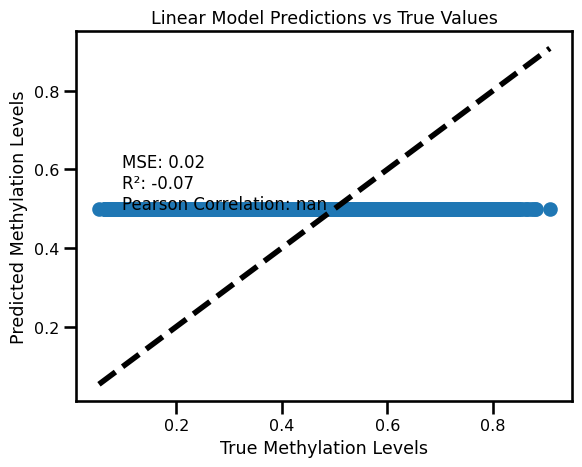

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Assuming linear_model and valloader are defined and properly set up


# Convert lists of tensors to a single tensor and then to numpy arrays
y_pred_np = yhat.mean().numpy().flatten()
y_true_np = y_test_reduced.numpy().flatten()

# Calculate metrics
mse = mean_squared_error(y_true_np, y_pred_np)
r2 = r2_score(y_true_np, y_pred_np)
pearson_corr, _ = pearsonr(y_true_np.flatten(), y_pred_np.flatten())

# Plot the Results
plt.scatter(y_true_np.flatten(), y_pred_np.flatten())
plt.xlabel("True Methylation Levels")
plt.ylabel("Predicted Methylation Levels")
plt.title("Linear Model Predictions vs True Values")
plt.plot(
    [y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], "k--", lw=4
)

x_text = y_true_np.min() + (y_true_np.max() - y_true_np.min()) * 0.05
y_text = y_pred_np.min() + (y_pred_np.max() - y_pred_np.min()) * 0.85

plt.text(
    x_text,
    y_text,
    f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
    fontsize=12,
)

plt.show()